In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

In [2]:
s_a = pd.read_csv('data/ab_test-redesign_sample_a.zip')
s_a.head(3)

,date,cid,transactions,revenue,group
0,2020-11-06,1.001648e+09,0,0,A
1,2020-11-06,1.001936e+09,0,0,A
2,2020-11-06,1.003214e+08,0,0,A


In [3]:
s_b = pd.read_csv('data/ab_test-redesign_sample_b.zip')
s_b.head(3)

,date,cid,transactions,revenue,group
0,2020-11-06,1.000135e+09,0,0,B
1,2020-11-06,1.001648e+09,0,0,B
2,2020-11-06,1.003214e+08,0,0,B


In [5]:
sample = pd.concat([s_a, s_b], ignore_index=True)
sample['date'] = pd.to_datetime(sample['date'])

In [6]:
daily_data = sample.groupby(['date','group']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'
}).reset_index().rename(columns={'cid': 'users_count'})
daily_data.head()

,date,group,users_count,transactions,revenue
0,2020-11-06,A,2576,16,1577279
1,2020-11-06,B,2499,19,996645
2,2020-11-07,A,2704,23,1721886
3,2020-11-07,B,2804,19,555499
4,2020-11-08,A,3354,25,846051


In [7]:
daily_data['cum_users_count'] = daily_data.groupby(['group'])['users_count'].cumsum()
daily_data['cum_trans'] = daily_data.groupby(['group'])['transactions'].cumsum()
daily_data['cum_revenue'] = daily_data.groupby(['group'])['revenue'].cumsum()
daily_data.head(4)

,date,group,users_count,transactions,revenue,cum_users_count,cum_trans,cum_revenue
0,2020-11-06,A,2576,16,1577279,2576,16,1577279
1,2020-11-06,B,2499,19,996645,2499,19,996645
2,2020-11-07,A,2704,23,1721886,5280,39,3299165
3,2020-11-07,B,2804,19,555499,5303,38,1552144


In [8]:
# вычисляем кумулятивную конверсию
daily_data['cum_conversion'] = daily_data['cum_trans']/daily_data['cum_users_count'] * 100
daily_data['avg_sale'] = daily_data['cum_revenue']/daily_data['cum_trans']
display(daily_data.head())

,date,group,users_count,transactions,revenue,cum_users_count,cum_trans,cum_revenue,cum_conversion,avg_sale
0,2020-11-06,A,2576,16,1577279,2576,16,1577279,0.621118,98579.937500
1,2020-11-06,B,2499,19,996645,2499,19,996645,0.760304,52455.000000
2,2020-11-07,A,2704,23,1721886,5280,39,3299165,0.738636,84593.974359
3,2020-11-07,B,2804,19,555499,5303,38,1552144,0.716576,40845.894737
4,2020-11-08,A,3354,25,846051,8634,64,4145216,0.741256,64769.000000


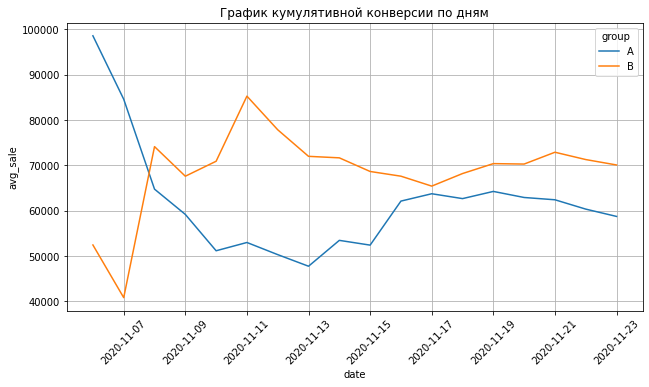

In [9]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='avg_sale', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

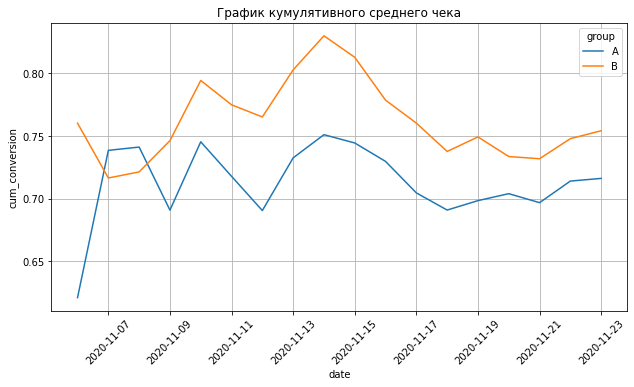

In [10]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='cum_conversion', data=daily_data, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

In [19]:
daily = sample.groupby(['date','group']).agg({
    'cid':'count',
    'transactions':'sum',
    'revenue':'sum'
}).reset_index().rename(columns={'cid': 'users_count'})
daily['avg_sale'] = round(daily.revenue / daily.transactions, 2)
daily.head()

,date,group,users_count,transactions,revenue,avg_sale
0,2020-11-06,A,2576,16,1577279,98579.94
1,2020-11-06,B,2499,19,996645,52455.00
2,2020-11-07,A,2704,23,1721886,74864.61
3,2020-11-07,B,2804,19,555499,29236.79
4,2020-11-08,A,3354,25,846051,33842.04


In [16]:
converted_piv= sample.groupby('group')['transactions'].agg(
    ['sum', 'count']
)
display(converted_piv)

,sum,count
group,,
A,441,61571
B,463,61383


In [18]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.1 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], #число "успехов"
    nobs=converted_piv['count'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))
 
# p-value:  0.1
# Принимаем нулевую гипотезу. Конверсии в группах А и B равны

p-value:  0.78
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


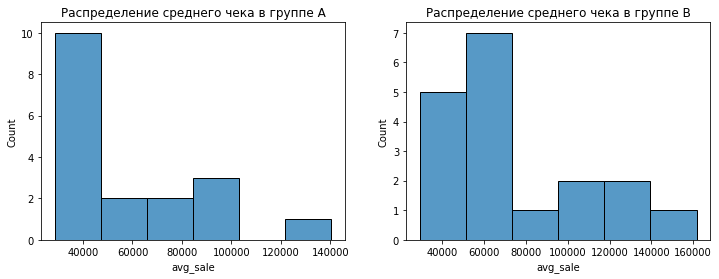

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='avg_sale', data=daily[daily['group'] == 'A'], ax=axes[0])
sns.histplot(x='avg_sale', data=daily[daily['group'] == 'B'], ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение среднего чека в группе А');
axes[1].set_title('Распределение среднего чека в группе B');

In [23]:
from scipy.stats import shapiro

# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'

alpha = 0.1 # уровень значимости

# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily[daily['group'] == 'A']['avg_sale'])
shapiro_result_b = shapiro(daily[daily['group'] == 'B']['avg_sale'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.01
p-value группы B 0.02
Отвергаем нулевую гипотезу. Распределения в обеих группах нормальные
Альтернативная гипотеза. H1: Распределение в одной или обеих группах отлично от нормального


In [25]:
from scipy.stats import mannwhitneyu

# нулевая и альтернативная гипотезы
H0 = 'Средний чек в группах одинаков'
H1 = 'Средней чек в группе А меньше, чем в группе B'

alpha = 0.1 #уровень значимости

#вычисляем результат T-теста для выборок
results = mannwhitneyu(
    daily[daily['group'] == 'A']['avg_sale'],
    daily[daily['group'] == 'B']['avg_sale'], 
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Принимаем нулевую гипотезу. {}".format(H0))

p-value: 0.09
Отвергаем нулевую гипотезу. Средний чек в группах одинаков
Альтернативная гипотеза. H1: Средней чек в группе А меньше, чем в группе B
